# **Resolução Numérica em Python da Equação do Movimento Longitudinal do Cessna 152 e Evolução do Ângulo de Ataque Sob Influência de Pequenas Pertubações**
Nome: Ruan Pablo Soares Machado

Professor: Leonardo Guerini

Curso: Engenharia Aeroespacial

---



## 1. Introdução

A Estabilidade pode ser entendida como: a tendência de uma aeronave de retornar a sua posição de equilíbrio após uma pertubação. A estabilidade longitudinal é uma das principais características dinâmicas da aeronave. Este trabalho visa modelar e simular numéricamente a resposta de uma aeronave (Cessna 152) a pequenas pertubações longitudinais, focando na variação do ângulo de ataque 'α' associados à arfagem(nariz subir ou descer) ao longo do tempo. A dinâmica longitudinal envolve os movimentos em torno do eixo lateral da aeronave (associados à arfagem, isto é, ao "nariz subir ou descer"). O trabalho parte da formulação linearizada do movimento longitudinal da aeronave, permitindo então a aplicação de métodos numéricos de resolução de equações diferenciais ordinárias.

## Modelo Longitudinal do Cessna 152

Para estudarmos o comportamento longidutinal, adotamos linearizar a equação do movimento longidudinal da aeronave em torno de um ponto de equilibrio - para uma análise completa da aeronave falamos de 12 equações de movimento que também icluem movimentos laterais e verticais e seus modos acoplados -
Dentro do movimento longitudinal, temos o:
Modo Phogoid (oscilação-lenta):
Modo short-Period (oscilaçao rápida):
e outras interações com a geometrias da aeronave e controle.

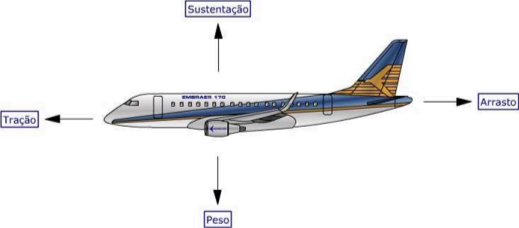

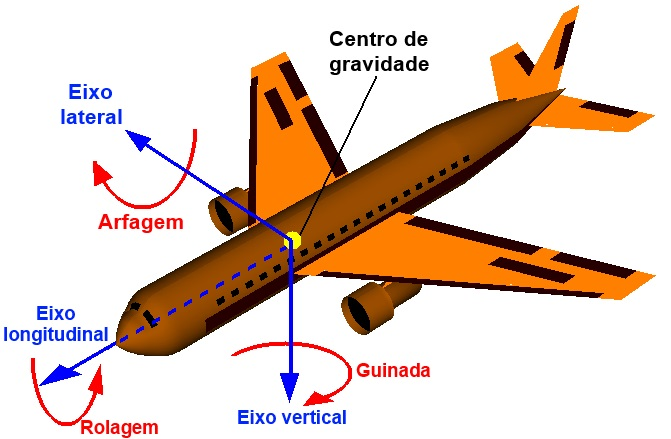

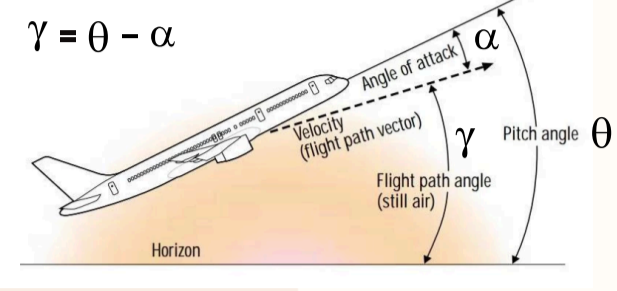

Neste notebook, iremos simular o comportamento **dinâmico longitudinal** do avião **Cessna 152** frente a pequenas perturbações em voo nivelado.

O foco está na modelagem e resolução numérica das **equações diferenciais ordinárias (EDOs)** que descrevem variações em:

- \( U' \): variação da velocidade longitudinal
- \( alpha' \): variação do ângulo de ataque
- \( theta' \): variação da inclinação (ângulo de arfagem)
- \( q' \): variação da velocidade angular de arfagem

Essas variáveis representam a resposta da aeronave a pequenas perturbações em voo, com foco em estabilidade e controle.

O notebook está dividido nas seguintes partes:

### 1️⃣ **Definição dos Parâmetros do Modelo**
Calculamos os coeficientes aerodinâmicos linearizados com base nos dados físicos e aerodinâmicos do Cessna 152 (massa, momento de inércia, coeficientes de sustentação, etc). Isso fornece os termos da matriz dinâmica do sistema linear.

### 2️⃣ **Definição da Função do Sistema**
Implementamos a função `edo_linear(t, y)`, que define as 4 EDOs acopladas de primeira ordem que governam o sistema linearizado. Essa função será utilizada pelo método numérico para integração.

### 3️⃣ **Condições Iniciais e Integração Numérica**
Definimos o vetor de estado inicial \( y_0 \), com uma leve perturbação em \( U \) e \( alpha ), e resolvemos o sistema com o método de **Runge-Kutta de 4ª ordem (RK4)** implementado manualmente. Também mostramos as constantes \( k_1 \), \( k_2 \), \( k_3 \), \( k_4 \) no **primeiro passo**, como ilustração didática do processo numérico.

### 4️⃣ **Resultado da Integração**
A matriz `sol` armazena a evolução temporal de todos os 4 estados ao longo do tempo.

### 5️⃣ **Visualização Gráfica**
Plotamos a evolução temporal das variáveis \( U' \), \( alpha' \), \( theta' \), \( q' \) usando gráficos individuais, para analisar visualmente a resposta da aeronave às perturbações iniciais.


## 🔧 Código 1 — Parâmetros da Aeronave e Derivadas Aerodinâmicas

Neste primeiro bloco, definimos os **parâmetros físicos e aerodinâmicos** do avião Cessna 152, como massa, área da asa, momento de inércia e velocidade de cruzeiro. Esses dados serão usados para calcular as **derivadas dimensionais**, que representam como as forças e momentos aerodinâmicos variam com as mudanças nos estados do voo (como velocidade, ângulo de ataque e taxa de arfagem).

Essas derivadas são essenciais para compor a **matriz dinâmica linearizada** do sistema, que descreve o comportamento da aeronave sob pequenas perturbações. Ao final do código, o script imprime os coeficientes calculados (como (X_u), (Z_α), (Z_q), etc), que servirão de base para a formulação das equações diferenciais do sistema no próximo bloco.

Por fim, poderemos ver a impressão dos coeficientes aerodinâmicos e físicos que descrevem a dinâmica longitudinal linearizada da aeronave.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# =======================
# PARÂMETROS DA AERONAVE
# =======================

m = 490.0           # Massa do Cessna 152 em kg
S = 14.86           # Área da asa (m²)
c = 1.4             # Corda média (m)
rho = 1.81          # Densidade do ar (kg/m³) a ~1000 m de altitude
g = 9.81            # Gravidade (m/s²)
Iyy = 1280.0        # Momento de inércia em arfagem ou seja a resistencia à rotação em torno do eixo de arfagem (passagem do nariz) (kg·m²)
V0 = 30.8           # Velocidade de voo de equilíbrio (m/s)

# Coeficientes aerodinâmicos típicos do Cessna 152

CD0 = 0.04          # Coeficiente de arrasto parasita (sem sustentação)
CL_alpha = 4.8      # Derivada da sustentação em relação a ao ângulo de ataque (alpha) (1/rad)
CL_q = 3.0          # Derivada da sustentação em relação à taxa de arfagem q (1/rad)
Cm_alpha = -0.5     # Derivada do momento em relação ao ângulo de ataque (alpha) (1/rad)
Cm_q = -4.0         # Derivada do momento em relação à taxa de arfagem (q) (1/rad)
theta0 = 0.0        # Ângulo de inclinação de equilíbrio ou seja é a inclinação da trajetória no voo em equilib - aqui considerado como nulo (voo nivelado) (rad)

# Esses coeficientes indicam como o avião reage as mudanças em alpha (ângulo de ataque) e q (velocidade angular)

# ===============================
# CÁLCULO DAS DERIVADAS DIMENSIONAIS
# ===============================

q_dyn = 0.5 * rho * V0**2  # Pressão dinâmica no voo de equilíbrio

Xu = -(q_dyn * S * 2 * CD0) / (m * V0)                 # Derivada de força longitudinal em relação a U (velocidade). O cálculo aproxima a força de arrasto como função da velocidade
Zalpha = -(q_dyn * S * CL_alpha) / m                   # Derivada da força vertical em relação a alpha - O quanto a força vertical muda com alpha
Zq = -(q_dyn * S * c * CL_q) / (2 * m * V0)            # Derivada da força vertical em relação a q - influencia da taxa de arfagem (q) na força vertical
Ztheta = -g * np.cos(theta0)                           # Componente gravitacional vertical - se o avião estiver inclinado o theta não vai ser mais 0 e sim diferente
Mu = (q_dyn * S * c * Cm_alpha) / Iyy                  # Derivada do momento em relação a alpha - como o angulo de ataque incluencia o momento
Mq = (q_dyn * S * c**2 * Cm_q) / (2 * V0 * Iyy)        # Derivada do momento em relação a q - como a taxa de arfagem influencia o momento


print("Xu = ", Xu)
print("Zalpha = ", Zalpha)
print("Zq = ", Zq)
print("Ztheta = ", Ztheta)
print("Mu = ", Mu)
print("Mq = ", Mq)
print("q_dyn = ", q_dyn)

Xu =  -0.06762573714285715
Zalpha =  -124.97236224
Zq =  -1.7751756
Ztheta =  -9.81
Mu =  -6.97680993625
Mq =  -1.2685108975
q_dyn =  858.5192000000001


## Código 2 — Definição do Sistema de EDOs Linearizadas
##  Equações Dinâmicas Longitudinais (não linearizadas)

O sistema completo da dinâmica longitudinal de uma aeronave (antes da linearização) é dado pelas seguintes equações diferenciais:

\
\begin{cases}
m \frac{dU}{dt} &= -D + T \cos(\alpha) - mg \sin(\theta) \\
m \frac{dW}{dt} &= L + T \sin(\alpha) - mg \cos(\theta) \\
I_{yy} \frac{dq}{dt} &= M \\
\frac{d\theta}{dt} &= q
\end{cases}

Essas equações descrevem a evolução temporal das variáveis de estado da aeronave sob a ação das forças e momentos aerodinâmicos e gravitacionais. São elas:

- ( U ) e ( W ): componentes da velocidade no eixo longitudinal e vertical, respectivamente,
- ( α ): ângulo de ataque,
- ( θ ): ângulo de inclinação (pitch),
- ( q ): velocidade angular em arfagem,
- ( D ), ( L ), ( M ): arrasto, sustentação e momento aerodinâmico,
- ( T ): empuxo,
- ( m ): massa da aeronave,
- ( I_yy ): momento de inércia em arfagem.

\
**Essas equações representam o modelo físico completo. No presente trabalho, partimos da sua versão linearizada em torno do ponto de equilíbrio, para facilitar a análise e simulação, relembrando já que iremos analisar apenas o movimento longitudinal da aeronave.**

\
Neste bloco, implementamos a função `edo_linear(t, y)` que representa o **sistema de equações diferenciais ordinárias (EDOs)** que governam a dinâmica longitudinal linearizada do Cessna 152. O vetor de estado ( y = [U', α', θ', q']) contém as quatro variáveis que descrevem o comportamento da aeronave frente a pequenas perturbações:

\
A linearização permite separar os efeitos das perturbações e escrever um sistema linear com coeficientes constantes

## Sistema de equações diferenciais linearizadas:

\
\begin{cases}
\frac{dU'}{dt} = X_u U' + Z_\alpha \alpha' + Z_q q' + Z_\theta \theta' \\
\frac{d\alpha'}{dt} = q' \\
\frac{d\theta'}{dt} = q' \\
\frac{dq'}{dt} = M_\alpha \alpha' + M_q q'
\end{cases}

\
A função retorna as derivadas de cada uma dessas variáveis no tempo, de acordo com os coeficientes calculados anteriormente (no Código 1).

\
Essas equações são utilizadas pelo método de Runge-Kutta no próximo bloco para simular numericamente a resposta do avião a uma perturbação.

**Resultado esperado:** definição da função `edo_linear`, que será usada como entrada no método de integração numérica.

O vetor edo_linear(t,y) retorna um vetor com 4 derivadas e, então usamos y = np.arange((n, 4)) matriz para armazenar todas as soluções no tempo e y[i+1] = y[i] + (h6) * (...) para atualizar todos os 4 estado simultaneamente.


\
### Aplicação do Método de Runge-Kutta de 4ª Ordem para o Sistema Longitudinal

Vamos usar o método de **Runge-Kutta de 4ª ordem** para resolver numericamente o **Problema de Valor Inicial (PVI)** definido por um **sistema de EDOs acopladas**, modelando a dinâmica longitudinal de uma aeronave (Cessna 152). O sistema é dado por:

\
\begin{cases}
\dfrac{dU'}{dt} = f_1(U', \alpha', \theta', q') \\
\dfrac{d\alpha'}{dt} = f_2(U', \alpha', \theta', q') \\
\dfrac{d\theta'}{dt} = f_3(U', \alpha', \theta', q') \\
\dfrac{dq'}{dt} = f_4(U', \alpha', \theta', q')
\end{cases}


Ou seja, trata-se de um **sistema com quatro variáveis de estado**:

- U' : perturbação na velocidade  
- α': perturbação no ângulo de ataque  
- θ': perturbação no ângulo de inclinação  
- q': perturbação na velocidade angular de arfagem  

A função que define a dinâmica, `edo_linear(t, y)`, recebe o vetor de estados \( y = [U', α', θ', q'] \) e retorna o vetor de derivadas de acordo com o modelo linearizado.

A solução será aproximada usando o método de Runge-Kutta 4ª ordem, com passo fixo \( h = 0,01 \), ao longo do intervalo de 0 a 20 segundos.

A condição inicial é uma perturbação de 0,5 m/s na velocidade e 1° no ângulo de ataque:

\
\begin{aligned}
y(0) = \begin{bmatrix}
0,5 \\
\text{rad}(1^\circ) \\
0 \\
0
\end{bmatrix}
\end{aligned}




In [ ]:
# =======================
# FUNÇÃO DO SISTEMA LINEARIZADO
# =======================

def edo_linear(t, y):
    # y = vetor de estado: [U', alpha', theta', q']
    U, alpha, theta, q = y

    # EDOs linearizadas
    dU_dt = Xu * U + Zalpha * alpha + Ztheta * theta + Zq * q
    dalpha_dt = q                       # d(alpha')/dt = q'
    dtheta_dt = q                       # d(theta')/dt = q'
    dq_dt = Mu * alpha + Mq * q         # d(q')/dt = M_alpha * alpha' + M_q * q'

    return [dU_dt, dalpha_dt, dtheta_dt, dq_dt]

### Interpretação do Primeiro Passo de Runge-Kutta de 4ª Ordem

Antes de resolver numericamente todo o sistema usando o método de Runge-Kutta de 4ª ordem, realizamos manualmente o **primeiro passo da integração**, utilizando os valores reais do modelo linearizado do Cessna 152.

#### Condição inicial:
\[
y_0 =
\begin{bmatrix}
0{,}5 \text{ m/s} \\
1^\circ = 0{,}01745 \text{ rad} \\
0 \\
0
\end{bmatrix}
\]

---

#### Cálculo dos coeficientes intermediários:

\
k_1 =
\begin{bmatrix}
-2{,}215 \\
0 \\
0 \\
-0{,}1218
\end{bmatrix}



k_2 =
\begin{bmatrix}
-2{,}213 \\
-0{,}00061 \\
-0{,}00061 \\
-0{,}1210
\end{bmatrix}



k_3 =
\begin{bmatrix}
-2{,}213 \\
-0{,}000605 \\
-0{,}000605 \\
-0{,}1210
\end{bmatrix}


\
k_4 =
\begin{bmatrix}
-2{,}211 \\
-0{,}00121 \\
-0{,}00121 \\
-0{,}1202
\end{bmatrix}


---

#### Resultado do próximo passo:

\
y_1
\begin{bmatrix}
0{,}478 \\
0{,}01745 \\
-6 \cdot 10^{-6} \\
-0{,}00121
\end{bmatrix}


---
Também estabelecemos o intervalo de simulação de 0 a 20 segundos, com passo de integração \( h = 0,01 \) s, totalizando 2000 pontos.

A seguir, aplicamos o método de Runge-Kutta de quarta ordem para resolver numericamente o sistema de equações diferenciais implementada anteriormente. Este método fornece uma solução precisa mesmo para sistemas não triviais, como é o caso da dinâmica de voo linearizada.

A função `runge_kutta` recebe a função que define o sistema (`edo_linear`), o vetor de tempo, a condição inicial e o passo \( h \), e *retorna uma matriz com a evolução de todos os estados ao longo do tempo.*

Além disso, imprimimos os vetores \( k_1, k_2, k_3, k_4 \) e o resultado \( y_1 \) do primeiro passo de Runge-Kutta, como uma forma de **verificação manual** do cálculo.

---

### Análise Física do Resultado

Já no primeiro passo, observamos que:
- A **velocidade perturbada** \( U' \) começa a **diminuir**. A velocidade longitudinal caiu levmente de 0.5 -> 0.478ms;
- A inclinação \( theta' \) torna-se **levemente negativa**, indicando uma tendência de **descida**;
- A velocidade angular \( q' \) também fica **negativa**, indicando um **movimento de arfagem para baixo** (momento picado), indicando manobra suave de estabilização.

Esses efeitos são **coerentes com uma resposta natural estável** do avião após uma perturbação suave no ângulo de ataque.



In [ ]:
# =======================
# CONDIÇÕES INICIAIS E SIMULAÇÃO
# =======================

# Pequena perturbação inicial no ângulo de ataque (1 grau ≈ 0.017 rad) e pertubação de 0.5ms na velocidade
# Os estados (theta0 e q0) começam em zero.
y0 = np.array([0.5, np.radians(1.0), 0.0, 0.0]) #[U0 , alpha0, theta0, q0]

# Intervalo de tempo da simulação
t = np.arange(0, 20, 0.01)

# =======================
# MÉTODO DE RUNGE-KUTTA DE 4ª ORDEM
# =======================

def runge_kutta(f, t, y0, h):
# Inicia o vetor solução y com zeros e aplica a condição inicial y0
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
# Aplicando RK4 para resolver as EDOs numéricamente
# Vai ser usada a média ponderada de quatro aproximações para obter a próxima posição no tempo
    for i in range(n-1):
        k1 = np.array(f(t[i], y[i]))
        k2 = np.array(f(t[i] + h/2, y[i] + h/2 * k1))
        k3 = np.array(f(t[i] + h/2, y[i] + h/2 * k2))
        k4 = np.array(f(t[i] + h, y[i] + h * k3))
        if i == 0:  # imprimir só no primeiro passo
          print("Passo 1 (t = {:.2f}):".format(t[i]))
          print("k1 =", k1)
          print("k2 =", k2)
          print("k3 =", k3)
          print("k4 =", k4)
          print("y1 =", y[i] + (h/6) * (k1 + 2*k2 + 2*k3 + k4))
        y[i+1] = y[i] + (h/6) * (k1 + 2*k2 + 2*k3 + k4) #Atualiza o indice

    return y # Retorna o vetor solução ao longo do tempo

# Resolvendo o sistema com Runge-Kutta com a função de integração numerica
sol = runge_kutta(edo_linear, t, y0, 0.01)

Passo 1 (t = 0.00):
k1 = [-2.21499206  0.          0.         -0.1217683 ]
k2 = [-2.21316231e+00 -6.08841523e-04 -6.08841523e-04 -1.20995983e-01]
k3 = [-2.21275948e+00 -6.04979913e-04 -6.04979913e-04 -1.20979642e-01]
k4 = [-2.21053266e+00 -1.20979642e-03 -1.20979642e-03 -1.20191456e-01]
y1 = [ 4.77871053e-01  1.74472301e-02 -6.06239882e-06 -1.20985168e-03]


Após resolver o sistema de equações diferenciais com o método de Runge-Kutta de 4ª ordem, a matriz sol contém a solução temporal aproximada do sistema dinâmico da aeronave.

O comando print(sol) exibe essa matriz, onde:

Cada linha representa um instante de tempo t𝑖;

Cada coluna representa uma variável de estado:

sol(t𝑖)= [𝑈′(𝑡𝑖) 𝛼′(𝑡𝑖)  𝜃′(𝑡𝑖)  𝑞′(𝑡𝑖) ]



In [ ]:
print(sol)

[[ 5.00000000e-01  1.74532925e-02  0.00000000e+00  0.00000000e+00]
 [ 4.77871053e-01  1.74472301e-02 -6.06239882e-06 -1.20985168e-03]
 [ 4.55794677e-01  1.74291491e-02 -2.41433988e-05 -2.40361449e-03]
 ...
 [ 1.90732142e+00  4.35216359e-08 -1.74532490e-02 -1.20987461e-07]
 [ 1.90774355e+00  4.23044252e-08 -1.74532502e-02 -1.22437461e-07]
 [ 1.90816540e+00  4.10732306e-08 -1.74532514e-02 -1.23784305e-07]]


Após a simulação numérica com o método de Runge-Kutta, os resultados são armazenados em uma matriz sol, com cada linha representando os valores das variáveis de estado em um determinado instante de tempo.

Este bloco de código utiliza o pacote matplotlib para visualizar a evolução no tempo das perturbações nas quatro variáveis do sistema dinâmico longitudinal da aeronave.

Esses gráficos ajudam a interpretar visualmente como a aeronave responde a pequenas perturbações iniciais, fornecendo uma noção clara dos modos de movimento (como o modo de período curto e o modo flogóide).

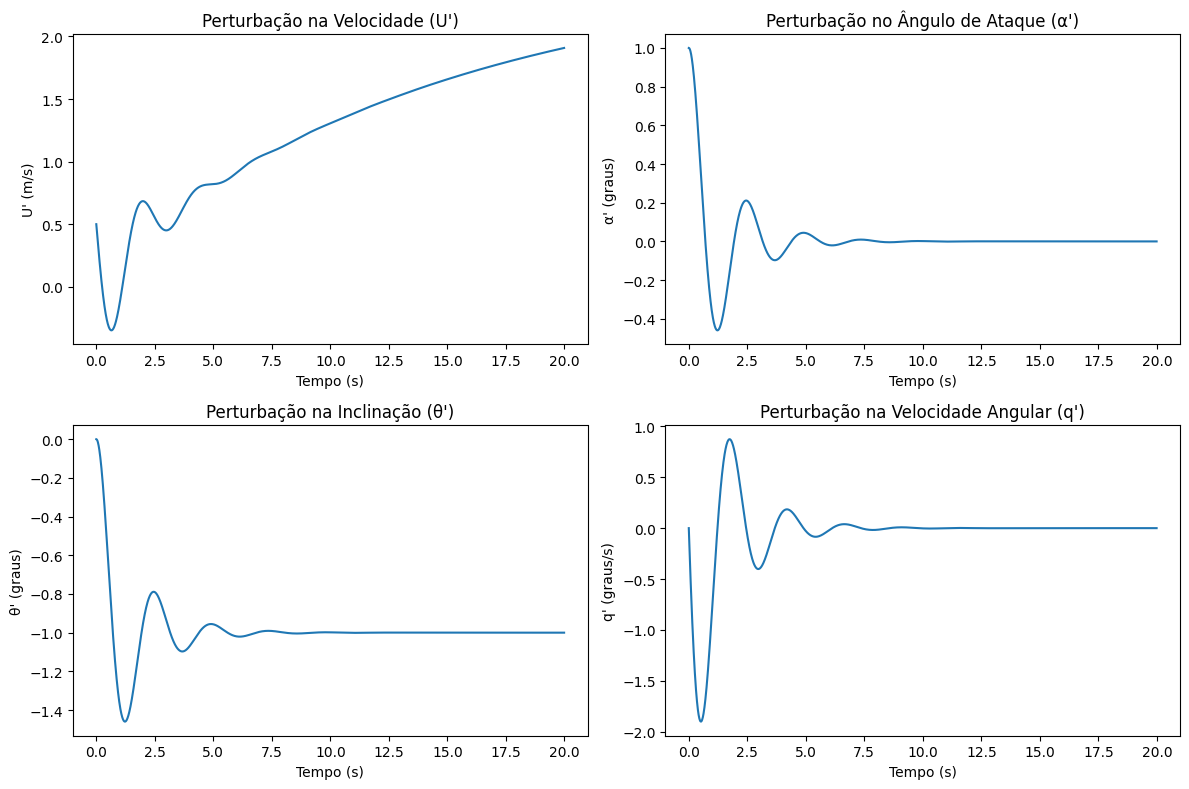

In [ ]:
# =======================
# PLOTAGEM DOS RESULTADOS
# =======================

plt.figure(figsize=(12, 8))
# Aqui os subplots irão exibir a evolução no tempo de uma variável de estado

# Velocidade U'
plt.subplot(2, 2, 1)
plt.plot(t, sol[:, 0]) # vetor tempo e a primeira coluna da matriz sol (primeiro estado do sistema)
plt.title("Perturbação na Velocidade (U')")
plt.xlabel("Tempo (s)")
plt.ylabel("U' (m/s)") # Pertubação na velocidade ao longo do tempo

# Ângulo de ataque α'
plt.subplot(2, 2, 2)
plt.plot(t, np.degrees(sol[:, 1])) # plotando o vetor tempo e todos os valores da segunda coluna da matriz sol (alpha de radianos pra graus)
plt.title("Perturbação no Ângulo de Ataque (α')")
plt.xlabel("Tempo (s)")
plt.ylabel("α' (graus)")

# Ângulo de inclinação θ'
plt.subplot(2, 2, 3)
plt.plot(t, np.degrees(sol[:, 2]))
plt.title("Perturbação na Inclinação (θ')")
plt.xlabel("Tempo (s)")
plt.ylabel("θ' (graus)")

# Velocidade angular q'
plt.subplot(2, 2, 4)
plt.plot(t, np.degrees(sol[:, 3]))
plt.title("Perturbação na Velocidade Angular (q')")
plt.xlabel("Tempo (s)")
plt.ylabel("q' (graus/s)")

plt.tight_layout()
plt.show()


## Interpretação dos Resultados da Simulação
A partir dos quatro gráficos gerados, é possível entender como a aeronave Cessna 152 se comporta após uma pequena perturbação no voo nivelado:

- 𝑈'(t) – Velocidade Longitudinal

Após a perturbação de +0.5 m/s, observa-se uma oscilação suave na velocidade ao longo do tempo. Isso reflete a troca de energia entre velocidade e altitude (característica do modo flogóide), típica de sistemas com baixa frequência e baixo amortecimento.

- 𝛼'(t) – Ângulo de Ataque

Uma pequena perturbação inicial em  desencadeia uma resposta oscilatória amortecida, indicando um modo de período curto: variações rápidas e bem amortecidas no nariz da aeronave, mantendo a estabilidade.

- 𝜃'(t) – Ângulo de Inclinação (Arfagem)

O ângulo de arfagem também oscila como consequência da perturbação em
𝛼, pois ambos estão acoplados. Sua evolução mostra a trajetória do nariz da aeronave ao longo do tempo, tendendo a se estabilizar.

- q'(t) – Velocidade Angular em Arfagem

O momento angular do avião responde rapidamente à perturbação inicial, com uma oscilação que também se amortiza ao longo do tempo. Isso está diretamente relacionado ao modo de período curto e ao momento de arfagem.



## Representação do Sistema com Matriz A

Nosso sistema de equações diferenciais (modelo linearizado do movimento longitudinal) pode ser representado de forma vetorial como:


$\frac{d}{dt}$
\begin{bmatrix}
U' \\
\alpha' \\
\theta' \\
q'
\end{bmatrix}
=
$A \cdot x$
\begin{bmatrix}
U' \\
\alpha' \\
\theta' \\
q'
\end{bmatrix}


Onde:

- \( U' \): perturbação na velocidade
- \( \alpha' \): perturbação no ângulo de ataque
- \( \theta' \): perturbação na inclinação da aeronave
- \( q' \): perturbação na velocidade angular (arfagem)
- \( A \): matriz dos coeficientes do sistema linearizado

A matriz \( A \) é dada por:


\
A =
\begin{bmatrix}
X_u & Z_\alpha & Z_\theta & Z_q \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 \\
0 & M_\alpha & 0 & M_q
\end{bmatrix}


Essa matriz 𝐴 representa a dinâmica linearizada do movimento longitudinal da aeronave Cessna 152, em torno de um ponto de equilíbrio (voo nivelado e retilíneo). Cada termo dela expressa como uma variável influencia a outra ao longo do tempo. É o modelo de espaço de estados, e tem o papel de "ditar" a evolução dos quatro estados do sistema:

---

###  Implementação em Python

No Python, usamos `numpy` para definir essa matriz e o vetor de estado \( x \):

```python
A = np.array([
    [Xu, Zalpha, Ztheta, Zq],
    [0,  0,      0,      1],
    [0,  0,      0,      1],
    [0,  Mu,     0,     Mq]
])

x = np.array([U, alpha, theta, q])
f = A @ x


In [ ]:
import sympy as sp

In [ ]:
# Dinâmica Longitudinal - Cessna 152

In [ ]:
# =============================================================
# DEFINIÇÃO DO SISTEMA DE EDOs LINEARIZADAS
# =============================================================
# f = (U', alpha', theta', q') = A @ x
# f é o vetor de derivadas de estado do sistema.
# A é a matriz de coeficientes do sistema linearizado (matriz jacobiana)
# x é o vetor de estado com U', a', 0', q'
#O sistema de EDO lineares é representado
def f(U, alpha, theta, q):
    dU_dt     = Xu * U + Zalpha * alpha + Ztheta * theta + Zq * q
    dalpha_dt = q
    dtheta_dt = q
    dq_dt     = Mu * alpha + Mq * q
    return np.array([dU_dt, dalpha_dt, dtheta_dt, dq_dt])

Nesse trecho do código ira ser gerado e plotado o campo de vetores no plano de fase (α,q), que representa graficamente como o sistema dinâmico evolui no espaço de estados reduzido, ou seja, focando só no ângulo de ataque (α) e na velocidade angular em arfagem (q).

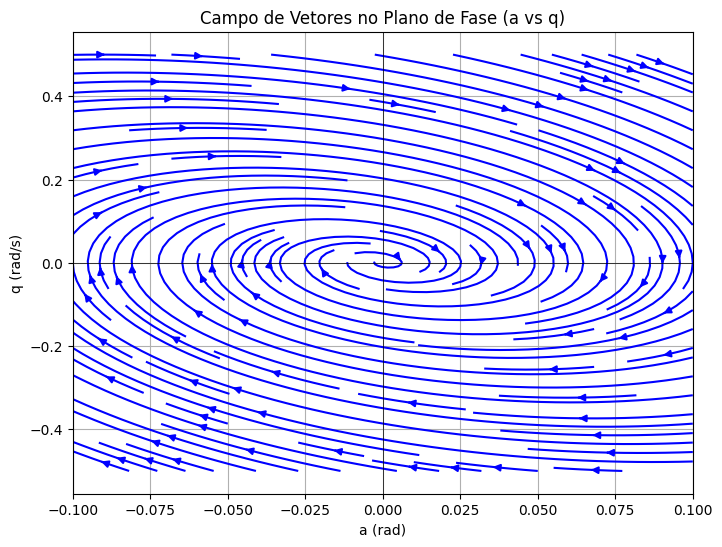

In [ ]:
# =============================================================
# PLOTAGEM DO CAMPO DE VETORES NO PLANO (alpha, q)

# Criando malha do plano (alpha, q)
# Grade de -0.1 a 0.1 rad apar alpha
# Grade de -0.5 a 0.5 rad/s para q
alpha_vals = np.linspace(-0.1, 0.1, 20)  # rad
q_vals = np.linspace(-0.5, 0.5, 20)      # rad/s

alpha_grid, q_grid = np.meshgrid(alpha_vals, q_vals)
dalpha_grid = np.zeros_like(alpha_grid)
dq_grid = np.zeros_like(q_grid)

# Consideramos U=0, theta=0 para o plano reduzido
for i in range(alpha_grid.shape[0]):
    for j in range(alpha_grid.shape[1]):
        a = alpha_grid[i, j]
        qv = q_grid[i, j]
        derivs = f(0.0, a, 0.0, qv) # Calculo das derivadas para cada ponto da malha, vai retornar os valores da alpha' e q'
        dalpha_grid[i, j] = derivs[1]  # dalpha/dt = q
        dq_grid[i, j] = derivs[3]      # dq/dt = Mu*alpha + Mq*q

plt.figure(figsize=(8, 6))
plt.streamplot(alpha_vals, q_vals, dalpha_grid, dq_grid, color='blue', density=1.5) # Linhas de corrente, o sistema evolui com o tempo naquele ponto do espaço de fase.
plt.xlabel("a (rad)")
plt.ylabel("q (rad/s)")
plt.title("Campo de Vetores no Plano de Fase (a vs q)")
plt.grid(True)
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.show()


## Interpretação física
Cada flecha mostra como o par
(𝛼, 𝑞) se move ao longo do tempo. Com isso, você pode observar:

- Se o sistema é estável (vetores convergem para a origem).

- O tipo de oscilação (modo periódico, amortecido, etc).

- Se existe amortecimento ou instabilidade.

# Simulando uma pertubação no ângulo de ataque (𝛼)
O trecho abaixo irá sobrepor a trajetória real de uma solução específica (obtida via Runge-Kutta) sobre o campo de vetores que já foi desenhado anteriormente. Com isso,  conseguimos visualizar a evolução exata do sistema no plano de fase (α,q) a partir de uma condição inicial.

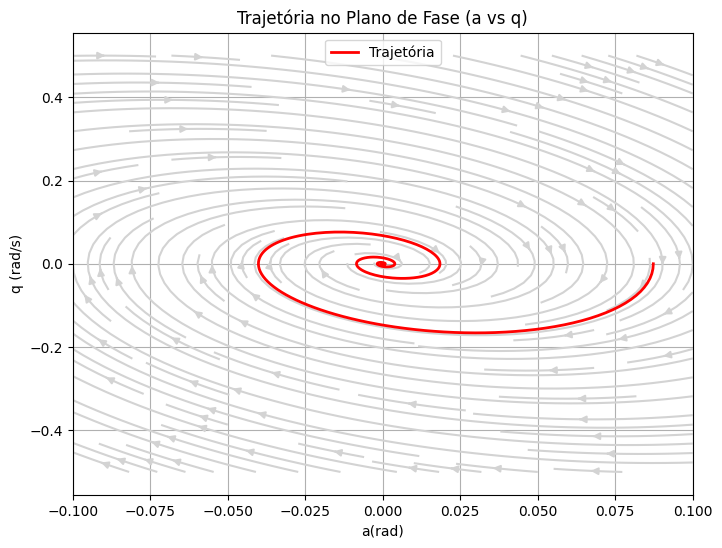

In [ ]:
# =============================================================
# TRAJETÓRIA DE UMA SOLUÇÃO PARTICULAR (Runge-Kutta)
# =============================================================
def runge_kutta(f, t, y0, h):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        k1 = f(*y[i])
        k2 = f(*(y[i] + h/2 * k1))
        k3 = f(*(y[i] + h/2 * k2))
        k4 = f(*(y[i] + h * k3))
        y[i+1] = y[i] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return y

# Condição inicial: perturbação em alpha (angulo de ataque)
y0 = [0.0, np.radians(5.0), 0.0, 0.0]
t = np.linspace(0, 20, 1000)
# Armazena todos os valores da solução no vetor sol.
sol = runge_kutta(f, t, y0, t[1] - t[0])

# Trajetória no plano alpha x q
plt.figure(figsize=(8, 6))
plt.streamplot(alpha_vals, q_vals, dalpha_grid, dq_grid, color='lightgray', density=1.5) # Vetores no fundo
plt.plot(sol[:, 1], sol[:, 3], 'r', linewidth=2, label="Trajetória") # Linha real da trajetória no plano (𝛼, q)
plt.xlabel("a(rad)")
plt.ylabel("q (rad/s)")
plt.title("Trajetória no Plano de Fase (a vs q)")
plt.legend()
plt.grid(True)
plt.show()

## Interpretação
Esse gráfico mostra como o sistema se move no plano de fase (α,q) partindo de uma perturbação inicial. A curva vermelha segue exatamente a dinâmica do avião, enquanto o campo de vetores mostra a tendência geral de todos os estados possíveis.

Se a curva espirala para o centro, há estabilidade amortecida (ex: modo de período curto). Se ela se afasta, há instabilidade.

# Análise dos Autovalores e Autovetores da Matriz da Dinâmica de Voo

A matriz 𝐴 representa a dinâmica linearizada da aeronave em torno do ponto de equilíbrio. Quando calculamos os autovalores de 𝐴, estamos descobrindo como o sistema reage às perturbações, se volta ao equilíbrio, se oscila, se cresce instável...

In [ ]:
# =============================================================
# AUTOVALORES E AUTOVETORES DA MATRIZ A
# =============================================================
A = sp.Matrix([
    [Xu, Zalpha, Ztheta, Zq],
    [0,     0,       0,   1],
    [0,     0,       0,   1],
    [0,    Mu,       0,  Mq]
])

sp.init_printing()
print("Matriz A do sistema:")
display(A)

print("\nAutovalores e autovetores:")
A.eigenvects()


Matriz A do sistema:


⎡-0.0676257371428571  -124.97236224   -9.81   -1.7751756  ⎤
⎢                                                         ⎥
⎢         0                 0           0          1      ⎥
⎢                                                         ⎥
⎢         0                 0           0          1      ⎥
⎢                                                         ⎥
⎣         0           -6.97680993625    0    -1.2685108975⎦


Autovalores e autovetores:


⎡⎛                        ⎡⎡1.0⎤⎤⎞  ⎛      ⎡⎡       -1.0        ⎤⎤⎞  ⎛         ↪
⎢⎜                        ⎢⎢   ⎥⎥⎟  ⎜      ⎢⎢                   ⎥⎥⎟  ⎜         ↪
⎢⎜                        ⎢⎢ 0 ⎥⎥⎟  ⎜      ⎢⎢         0         ⎥⎥⎟  ⎜         ↪
⎢⎜-0.0676257371428571, 1, ⎢⎢   ⎥⎥⎟, ⎜0, 1, ⎢⎢                   ⎥⎥⎟, ⎜-0.63425 ↪
⎢⎜                        ⎢⎢ 0 ⎥⎥⎟  ⎜      ⎢⎢0.00689355118683559⎥⎥⎟  ⎜         ↪
⎢⎜                        ⎢⎢   ⎥⎥⎟  ⎜      ⎢⎢                   ⎥⎥⎟  ⎜         ↪
⎣⎝                        ⎣⎣ 0 ⎦⎦⎠  ⎝      ⎣⎣         0         ⎦⎦⎠  ⎝         ↪

↪                                 ⎡⎡  -0.051359791580488 + 0.113197069235044⋅ⅈ ↪
↪                                 ⎢⎢                                           ↪
↪                                 ⎢⎢-0.00236936675805781 - 0.00058608977331802 ↪
↪ 544875 - 2.56408462457481⋅ⅈ, 1, ⎢⎢                                           ↪
↪                                 ⎢⎢-0.00236936675805781 - 0.00058608977331802 ↪
↪                          

Polos do sistema:
Polo 1: -0.0676+0.0000j
Polo 2: 0.0000+0.0000j
Polo 3: -0.6343+2.5641j
Polo 4: -0.6343-2.5641j


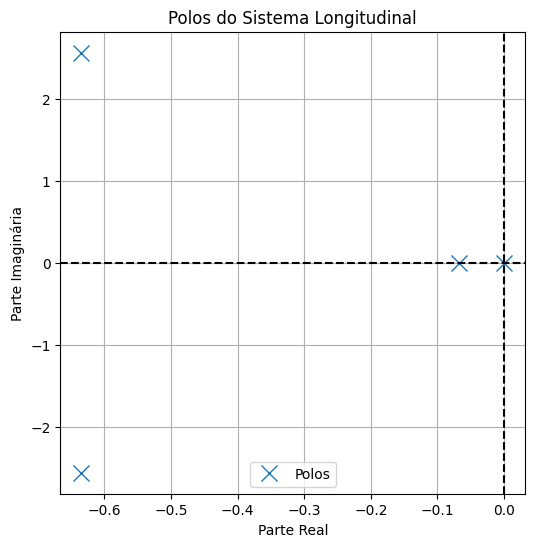

In [ ]:

# =======================
# CÁLCULO E PLOTAGEM DOS PÓLOS
# =======================
#A matriz A representa o sistema linearizado no formato x= Ax, e seus autovalores (polos) indicam se o sistema vai ser estável (parte real negativa) ou instável
A = np.array([
    [Xu,     Zalpha, Ztheta, Zq], # 1ª linha: (derivadas força longitudinal)
    [0,         0,      0,    1], # 2ª linha: Relação entre theta' e q
    [0,         0,      0,    1], # 3ª linha: Atenção: essa linha é repetida e pode ser um erro - geralmente dtheta/dt = q, mas d(alpha)/dt não é 1 * q
    [0,        Mu,      0,   Mq]
])
polos = np.linalg.eigvals(A) # Calcula os autovalores (polos) do sistema

print("Polos do sistema:")
for i, p in enumerate(polos):
    print(f"Polo {i+1}: {p:.4f}")

plt.figure(figsize=(6,6))
plt.plot(polos.real, polos.imag, 'x', markersize=12, label='Polos')
plt.axvline(0, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.title('Polos do Sistema Longitudinal')
plt.grid(True)
plt.legend()
plt.show()

#Conclusão

Neste trabalho, modelamos a dinâmica longitudinal linearizada da aeronave Cessna 152 sob pequenas perturbações em torno de um ponto de equilíbrio em voo nivelado. O sistema foi descrito por quatro variáveis de estado: perturbações na velocidade
𝑈', ângulo de ataque  𝛼', ângulo de inclinação 𝜃 e velocidade angular de arfagem q'.

A partir dos parâmetros físicos e aerodinâmicos do modelo, obtivemos as derivadas de estabilidade, que compuseram a matriz dinâmica 𝐴 do sistema linearizado. Em seguida, implementamos uma simulação numérica via método de Runge-Kutta de 4ª ordem, analisando a resposta temporal do sistema para uma condição inicial com pequenas perturbações.

Além disso, representamos graficamente o campo de vetores no plano de fase (𝛼,𝑞)
, evidenciando o comportamento dinâmico ao redor do equilíbrio. Foi possível observar uma trajetória típica de retorno estável, com oscilações amortecidas, representando a resposta natural da aeronave a distúrbios suaves.

A análise dos autovalores da matriz 𝐴 confirmou a presença dos dois modos clássicos da dinâmica longitudinal:

- Um modo oscilatório amortecido (com autovalores complexos conjugados), que representa o modo de período curto da aeronave;

- Um modo real negativo mais lento, associado ao amortecimento suave do modo phugoid.

Esses resultados mostram que o sistema é estável, pois todos os autovalores possuem parte real negativa, e que a resposta natural do Cessna 152 tende ao equilíbrio após uma perturbação.

<center>
  <img src="(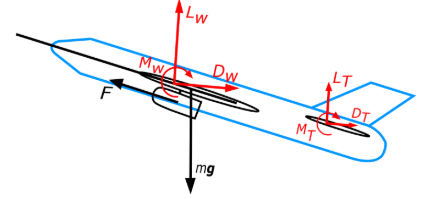)" width="300"/>
</center>